<h2>Load dataset from Google Colab</h2>

In [1]:
!pip install kaggle

In [2]:
!git clone https://github.com/sicara/easy-few-shot-learning
%cd easy-few-shot-learning
!pip install .

Cloning into 'easy-few-shot-learning'...
remote: Enumerating objects: 1160, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 1160 (delta 264), reused 242 (delta 189), pack-reused 737
Receiving objects: 100% (1160/1160), 2.32 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (668/668), done.
/content/easy-few-shot-learning
Processing /content/easy-few-shot-learning
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for easyfsl: filename=easyfsl-1.5.0-py3-none-any.whl size=72797 sha256=80f2c8046ca6a55fff266e194c83702c62056c1c0417e8af5787e51931790c6c
  Stored in directory: /root/.cache/pip/wheels/bb/79/35/1da2d9ffa9c9b6892f0cca4cda77ee397b97a1deda949049e2
Successfully built easyfsl


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d arjunashok33/miniimagenet

100% 6.28G/6.28G [05:22<00:00, 23.6MB/s]
100% 6.28G/6.28G [05:22<00:00, 20.9MB/s]


<h2>Unzip Dataset</h2>

In [8]:
zip_path = '/content/easy-few-shot-learning/miniimagenet.zip'
extract_path = '/content/easy-few-shot-learning/data/mini_imagenet'

!unzip -qo {zip_path} -d {extract_path}

<h2>Download Dataset</h2>

In [9]:
from easyfsl.datasets import MiniImageNet

train_set = MiniImageNet(root="/content/easy-few-shot-learning/data/mini_imagenet", split="train", training=True)
test_set = MiniImageNet(root="/content/easy-few-shot-learning/data/mini_imagenet", split="test", training=False)

In [10]:
print(len(test_set),len(train_set))

12000 38400


torch.Size([3, 84, 84])


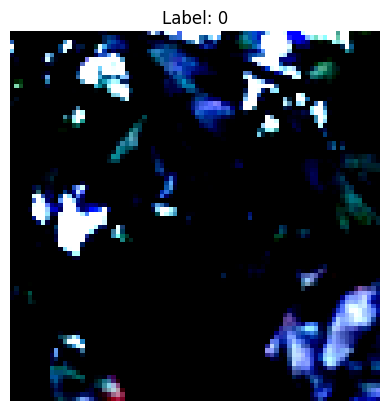

In [11]:
import matplotlib.pyplot as plt

image_index = 220

dataset = train_set

image, label = dataset[image_index]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [12]:
import torch
# Get the tuple from train_set
tuple_data = train_set[10]

# Iterate over each element in the tuple
max_value = float('inf')  # Initialize with a very small value

for element in tuple_data:
    if isinstance(element, torch.Tensor):
        element_max = torch.min(element)
        max_value = min(max_value, element_max)
    else:
        max_value = min(max_value, element)

print(max_value)

tensor(-1.2274)


<h2>Start train and test</h2>

In [13]:
import os
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn, optim

In [14]:
ImageSize=84

In [15]:
print(len(train_set),len(test_set))

38400 12000


torch.Size([3, 84, 84])


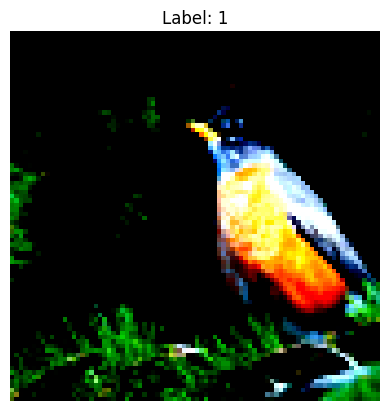

In [16]:
import matplotlib.pyplot as plt

image_index = 750

dataset = train_set

image, label = dataset[image_index]
print(image.shape)
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

<h2>Implement Prototypical Network</h2>

In [17]:
from torchvision.models import resnet18

In [18]:
class PrototypicalNetworks(nn.Module):
  def __init__(self,backbone:nn.Module):
    super(PrototypicalNetworks,self).__init__()
    self.backbone=backbone
  def forward(self,support_images:torch.Tensor,support_labels:torch.Tensor,query_images: torch.Tensor):

    z_support=self.backbone.forward(support_images)
    z_query=self.backbone.forward(query_images)

    n_way=len(torch.unique(support_labels))

    z_proto = torch.cat(
        [
            z_support[torch.nonzero(support_labels == label)].mean(0)
            for label in range(n_way)
        ]
    )

    dists = torch.cdist(z_query, z_proto)
    scores = -dists
    return scores


In [19]:
from torchsummary import summary

convolutional_network=resnet18(pretrained=True)
convolutional_network.fc=nn.Flatten()

# print(convolutional_network)

model=PrototypicalNetworks(convolutional_network).cuda()

# Print the summary of the model
summary(convolutional_network, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<h2>Create Support and Query Images</h2>

In [20]:
!pip install easyfsl

In [21]:
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average
from torch.utils.data import Dataset


In [22]:
print(len(test_set))

12000


In [23]:
print(len(os.listdir('/content/easy-few-shot-learning/data/mini_imagenet')))

103


In [24]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100


# # Assign the lambda function to get_labels
test_set.get_labels = lambda: [test_set[i][1] for i in range(len(test_set)) if i < len(test_set)]

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [25]:
print(len(test_sampler))
print(len(test_loader))

100
100


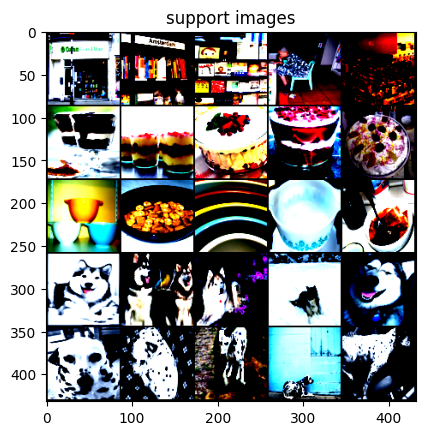

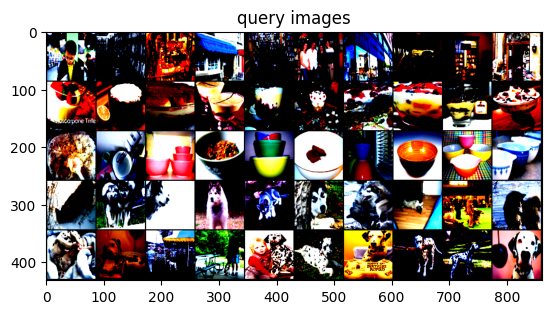

In [26]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [27]:
print(example_support_labels)
print(example_query_labels)

tensor([2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1])
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])


In [28]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print(example_predicted_labels)
# print("Ground Truth / Predicted")
# for i in range(len(example_query_labels)):
#     print(
#         f"{test_dataset._characters[example_class_ids[example_query_labels[i]]]} / {test_dataset._characters[example_class_ids[example_predicted_labels[i]]]}"
#     )

tensor([3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 1, 0, 0, 2, 2, 0, 1, 1, 2, 2, 1, 1, 1, 1,
        1, 1], device='cuda:0')


In [29]:
from tqdm import tqdm

In [30]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]

Model tested on 100 tasks. Accuracy: 83.06%


<h2>Train the model</h2>

In [31]:
N_TRAINING_EPISODES = 4000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [train_set[i][1] for i in range(len(train_set))]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

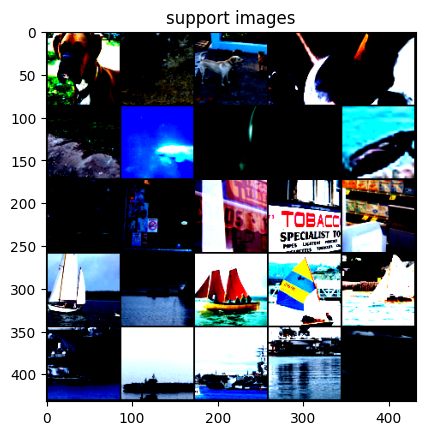

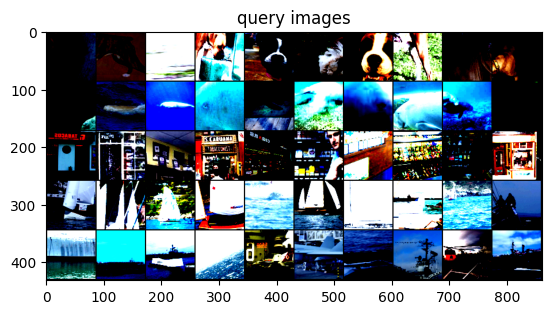

In [32]:
(
    example_support_images_train,
    example_support_labels_train,
    example_query_images_train,
    example_query_labels_train,
    example_class_ids_train,
) = next(iter(train_loader))

plot_images(example_support_images_train, "support images", images_per_row=N_SHOT)
plot_images(example_query_images_train, "query images", images_per_row=N_QUERY)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [34]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 4000/4000 [24:53<00:00,  2.68it/s, loss=0.726]


In [35]:
# Save the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/prototypical2.pth')

In [36]:
evaluate(test_loader)

100%|██████████| 100/100 [00:34<00:00,  2.90it/s]

Model tested on 100 tasks. Accuracy: 63.82%


In [ ]:
evaluate(train_loader)

  8%|▊         | 307/4000 [02:01<31:52,  1.93it/s]